# SQD for ATP

## Set experiment parameters

In [187]:
ibm_computer: str = "ibm_torino"
qubits = [3, 16, 17, 18, 19] + list(range(20, 79))
nshots: int = 100_000

nqubits = len(qubits)
nqubits

64

## Setup

In [188]:
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import numpy as np
import pickle

import openfermion as of

import qiskit
from qiskit import qasm2, qasm3
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [189]:
# Skip this cell if not running on hardware.
service = qiskit_ibm_runtime.QiskitRuntimeService(name="NERSC-US")
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

## Read in the Hamiltonian and ansatz circuit

In [190]:
fragment = "atp_0_be2_f4"

In [191]:
circuit_dir =  "circuits"
circuit_fname = "atp_0_be2_f4_030_adaptiterations.qasm"
circuit_path = f"{circuit_dir}/{fragment}/{circuit_fname}"
circuit_path

'circuits/atp_0_be2_f4/atp_0_be2_f4_030_adaptiterations.qasm'

In [192]:
circuit = qasm3.load(circuit_path)
circuit.draw(fold=-1, idle_wires=False)

┌───┐ ░                                              ░                                                                                                                  ░  ░                                                                                                                 ░                                                                                                 ░                                                                                                                  ░                                                                                ░                                                                                                             ░                                                                                                                                   ░                                                                                                                   ░                                                               ░                                                                                                                  ░                                                                                                                                                                                      ░                                                                                                                ░                                                                                                 ░                                                                                                                           ░                                                                                                                                                    ░                                                                                                                            ░                                                                                ░                                                                                                                   ░  ░                                                                                                                 ░                                                                                                                                                                                      ░                                                                                                                  ░ ┌───┐┌───┐     ┌───┐┌──────────┐             ░                                                                                                                              ░  ░                                                                                                                            ░                                                                                                 ░                                                                                                                ░                                                                                                 ░                                                                                                                  ░                                                               ░                                                                                                                  ░ ┌───┐┌───┐     ┌───┐┌──────────┐                                               ░                                                                                                                       ░                                                                                                 ░                                                                                                                ░                                                                                                                                   ░                              

In [193]:
len(circuit.qubits)

64

In [194]:
# from qiskit.converters import circuit_to_dag, dag_to_circuit


# dag = circuit_to_dag(circuit)
# print(list(dag.idle_wires()))
# dag.remove_qubits(*list(dag.idle_wires()))
# circuit = dag_to_circuit(dag)

In [195]:
base = circuit.copy()
base = qiskit.transpiler.passes.RemoveBarriers()(base)

In [196]:
base.count_ops()

OrderedDict([('rz', 435),
             ('cx', 302),
             ('sx', 186),
             ('s', 147),
             ('h', 54),
             ('x', 16)])

## Prepare to run on hardware

In [197]:
to_run = base.copy()
to_run.measure_all()
to_run = [to_run]

In [198]:
to_run = qiskit.transpile(
    to_run,
    optimization_level=3,
    backend=computer,
    initial_layout=qubits,
    seed_transpiler=123
)

In [199]:
for c in to_run:
    print(c.count_ops())

OrderedDict([('sx', 1194), ('rz', 656), ('cz', 580), ('measure', 64), ('x', 15), ('barrier', 1)])


In [200]:
to_run[0].depth()

648

In [201]:
ops = list(to_run[0].count_ops().keys())
num = list(to_run[0].count_ops().values())

In [202]:
sum([number for op, number in to_run[0].count_ops().items() if op != "cz"])

1930

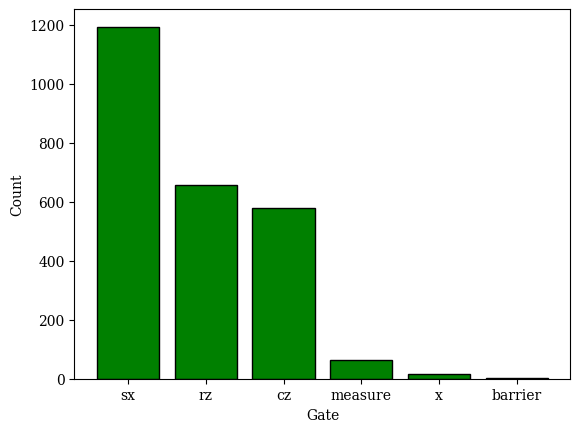

In [203]:
plt.bar(ops, num, color="green", edgecolor="black")
plt.xlabel("Gate")
plt.ylabel("Count");

In [204]:
# to_run[0].draw(fold=-1, idle_wires=False)

## Run on exact simulator

In [205]:
# simulator = AerSimulator(method="matrix_product_state")
# result = simulator.run(to_run, shots=10)
# counts = result.result().get_counts()
# counts

In [206]:
# hartree_fock_bitstring = list(counts.keys())[0]
# hartree_fock_bitstring

## Run on noisy simulator

In [207]:
# sim = AerSimulator.from_backend(computer, method="matrix_product_state")

In [208]:
# result = sim.run(to_run, shots=nshots)
# counts = result.result().get_counts()

In [146]:
# qiskit.visualization.plot_histogram(
#     counts,
#     target_string=hartree_fock_bitstring,
#     sort="hamming",
#     number_to_keep=10,
#     figsize=(7, 8),
#     title=sim.name,
# )

## Run on hardware

In [147]:
job = sampler.run(to_run, shots=nshots)
# job = service.job("d5n5uarh36vs73bitksg")

In [148]:
all_counts_hardware = []

In [149]:
res = job.result()

In [150]:
for r in res:
    all_counts_hardware.append(r.data.meas.get_counts())

In [151]:
len(all_counts_hardware[0])

99842

In [152]:
# import qiskit.visualization


# qiskit.visualization.plot_histogram(
#     all_counts_hardware[0],
#     target_string=hartree_fock_bitstring,
#     sort="hamming",
#     number_to_keep=10,
#     figsize=(7, 8),
#     title=computer.name,
# )

## Save data

In [153]:
import datetime


time_key = datetime.datetime.now().strftime("%Y_%m_%d_%H:%M:%S")
fname = circuit_fname + f"_counts_{computer.name}_nshots_{nshots}_{time_key}"
fname

'atp_0_be2_f4_030_adaptiterations.qasm_counts_ibm_torino_nshots_100000_2026_01_21_18:30:25'

In [154]:
pickle.dump(all_counts_hardware[0], open(fname, "wb"))

## Run SQD

In [209]:
import pyscf.tools

import collections
from functools import partial
import os

from qiskit.primitives import BitArray
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

In [210]:
circuit_fname

'atp_0_be2_f4_030_adaptiterations.qasm'

In [212]:
mode_order = pickle.load(
    open(f"{circuit_dir}/{fragment}/atp_0_be2_f4_mode_order_030_adaptiterations.pkl", "rb")
)
qubit_order = pickle.load(
    open(f"{circuit_dir}/{fragment}/atp_0_be2_f4_qubit_order_030_adaptiterations.pkl", "rb")
)

In [213]:
hamiltonian_dir = "hamiltonians"

In [224]:
ls hamiltonians/

atp_0_be1_f19.fcidump  atp_0_be1_f8.fcidump    atp_0_be2_f4.fcidump
atp_0_be1_f1.fcidump   atp_0_be2_f456.fcidump


In [237]:
import pyscf.tools

pyscf.tools.fcidump.read("./hamiltonians/atp_0_be1_f1.fcidump").get("H2").shape

Parsing ./hamiltonians/atp_0_be1_f1.fcidump


(1540,)

In [223]:
fragment

'atp_0_be2_f4'

In [214]:
fcidump = pyscf.tools.fcidump.read(f"{hamiltonian_dir}/{fragment}.fcidump")

Parsing hamiltonians/atp_0_be2_f4.fcidump


In [215]:
n_orbitals = fcidump.get("NORB")
num_electrons = fcidump.get("NELEC")
ecore = fcidump.get("ECORE")
h1 = fcidump.get("H1")
h2 = fcidump.get("H2")

In [216]:
h1.shape

(32, 32)

In [217]:
h2.shape

(139656,)

In [218]:
energy_tol = 1e-8
occupancies_tol = 1e-8
carryover_threshold = 1e-5

In [219]:
counts = pickle.load(
    open('atp_0_be2_f4_030_adaptiterations.qasm_counts_ibm_torino_nshots_100000_2026_01_21_18:30:25', "rb")
)

In [220]:
measurement_outcomes = counts
permuted_outcomes = {}
for original_bitstring in measurement_outcomes.keys():
    qubit_permuted_bitstring = "".join([original_bitstring[qubit_order.index(n)] for n in range(nqubits)])
    mode_permuted_bitstring = "".join([qubit_permuted_bitstring[mode_order.index(n)] for n in range(nqubits)])
    permuted_outcomes[mode_permuted_bitstring] = measurement_outcomes[original_bitstring]

bit_array = BitArray.from_counts(permuted_outcomes)
counts = bit_array.get_counts()
max_key = max(counts, key=counts.get)
print(f'Most common bitstring: {max_key} with count {counts[max_key]}')
print(f'Total number of bitstrings: {len(counts)}')
print(f"Total number of samples:", sum(counts.values()))

Most common bitstring: 1111111010110100111100000000000000000000000000000000000000001000 with count 2
Total number of bitstrings: 99842
Total number of samples: 100000


In [221]:
# SQD code.
sci_solver = partial(solve_sci_batch, spin_sq=0, max_cycle=10000)
result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + ecore}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


result = diagonalize_fermionic_hamiltonian(
    one_body_tensor=h1,
    two_body_tensor=h2,
    bit_array=bit_array,
    samples_per_batch=10,
    norb=n_orbitals,
    nelec=(num_electrons // 2, num_electrons // 2),
    num_batches=2,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=100,
    sci_solver=sci_solver,
    symmetrize_spin=True,
    carryover_threshold=carryover_threshold,
    callback=callback
)

ValueError: The input bit array did not contain any valid bitstrings. Either pass a bit array that contains at least one valid bitstring (with the correct right and left Hamming weights), or specify a value for initial_occupancies.